In [1]:
%pip install medmnist
%pip install torcheval

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from torchvision import models
import random
from torcheval.metrics import BinaryAUPRC

import medmnist
from medmnist import INFO, Evaluator

In [3]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.1 @ https://github.com/MedMNIST/MedMNIST/


In [4]:
data_flag = 'breastmnist'
download = True

BATCH_SIZE = 32

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# Deliverable 1

## First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [5]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)
validation_dataset = DataClass(split='val', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
validation_loader = data.DataLoader(dataset=validation_dataset, batch_size=BATCH_SIZE, shuffle=False)

Using downloaded and verified file: C:\Users\zayaa\.medmnist\breastmnist.npz
Using downloaded and verified file: C:\Users\zayaa\.medmnist\breastmnist.npz
Using downloaded and verified file: C:\Users\zayaa\.medmnist\breastmnist.npz
Using downloaded and verified file: C:\Users\zayaa\.medmnist\breastmnist.npz


In [6]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset BreastMNIST of size 28 (breastmnist)
    Number of datapoints: 546
    Root location: C:\Users\zayaa\.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0
Dataset BreastMNIST of size 28 (breastmnist)
    Number of datapoints: 156
    Root location: C:\Users\zayaa\.medmnist
    Split: test
    Task: binary-class
    Number of channels: 1
    M

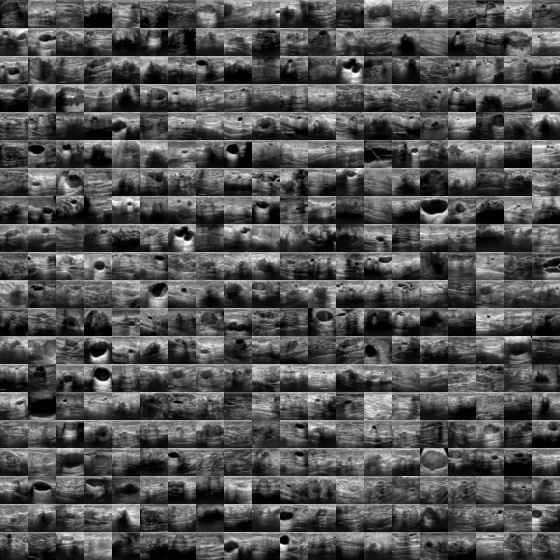

In [7]:
# montage

train_dataset.montage(length=20)

## Define seeing to make model results deterministic

In [8]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(0)

## Define ResNet18 - a simple model for illustration

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class ExtendedNetwork(nn.Module):
    def __init__(self, n_classes=2):
        # super(ExtendedNetwork, self).__init__()
        super().__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
       # self.resnet.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Freeze all layers of the original ResNet18 model
        num_features = self.resnet.fc.in_features
        # self.resnet.fc = nn.Linear(num_features, 512)
        self.resnet.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.resnet.fc = nn.Linear(num_features, n_classes)
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(512, n_classes),
        )

    def forward(self, x):
        x = self.resnet(x)    # Pass input through ResNet18
        return x
    

# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()

network = ExtendedNetwork(n_classes=n_classes)
network.to(device)

c:\Users\zayaa\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\zayaa\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ExtendedNetwork(
  (resnet): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

## Install Optuna for hyperparameter selection

In [10]:
%pip install optuna

## Defining modified test function to be used in training

In [11]:
def test(split):
    # Load the model with the best accuracy
    network.load_state_dict(torch.load('best_model.pth'))
    network.eval()
    y_true = torch.tensor([], device=device)
    y_score = torch.tensor([], device=device)
    collected_inputs = torch.tensor([], device=device)
    collected_targets = torch.tensor([], device=device)

    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = network(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1).squeeze()

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)
            collected_inputs = torch.cat((collected_inputs, inputs), 0)
            collected_targets = torch.cat((collected_targets, targets), 0)

        y_true = y_true.cpu().numpy()
        y_score = y_score.cpu().detach().numpy()
        collected_inputs = collected_inputs.detach().cpu()
        collected_targets = collected_targets.detach().cpu()

        evaluator = Evaluator(data_flag, split)
        auc, acc = evaluator.evaluate(y_score)

        # print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

        return (split, auc, acc), y_true, y_score

# print('==> Evaluating ...')
# train_inputs, train_targets, train_true, train_scores = test('train')
# test_inputs, test_targets, test_true, test_scores = test('test')

## Defining the accuracy function

In [12]:
def accuracy(outputs, targets):
    pred = outputs.argmax(dim=1, keepdim=True)
    correct = pred.eq(targets.view_as(pred)).sum().item()
    return correct / len(targets)

## Next, we can start to train and evaluate!

In [13]:
def validate_model(network, valid_loader, criterion, device):
    network.eval()  # Set the network to evaluation mode
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for validation_inputs, validation_targets in valid_loader:
            validation_inputs, validation_targets = validation_inputs.to(device), validation_targets.to(device)
            output = network(validation_inputs)
            validation_targets = validation_targets.squeeze().long()
            loss = criterion(output, validation_targets)
            total_loss += loss.item() * validation_inputs.size(0)  # Multiply by batch size
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            total_correct += pred.eq(validation_targets.view_as(pred)).sum().item()
            total_samples += validation_inputs.size(0)

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples * 100  # percentage accuracy
    return avg_loss, accuracy

In [14]:
import optuna
from torch.optim import lr_scheduler

results_dict = {}

def objective(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)
    patience = trial.suggest_int('patience', 5, 10)

    optimizer = optim.Adagrad(network.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=patience, threshold=0.0001, threshold_mode="abs")
    
    # define EPOCHS for optuna
    NUM_EPOCHS = 5
    best_validation_loss = float("inf")

    print("TRIAL:", trial.number)
    # train
    for epoch in range(NUM_EPOCHS):
        network.train()
        for train_inputs, train_targets in tqdm(train_loader):
            train_inputs = train_inputs.to(device)
            train_targets = train_targets.to(device)
            optimizer.zero_grad()
            outputs = network(train_inputs)

            if task == 'multi-label, binary-class':
                train_targets = train_targets.to(torch.float32)
                loss = criterion(outputs, train_targets)
            else:
                train_targets = train_targets.squeeze().long()
                loss = criterion(outputs, train_targets)

            loss.backward()
            optimizer.step()
            
        print(loss)

    # validate
    network.eval()


    validation_loss, validation_accuracy = validate_model(network, validation_loader, criterion, device)
    print('Validation - Loss: {:.6f}, Accuracy: {:.2f}%'.format(validation_loss, validation_accuracy))

    if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        torch.save(network.state_dict(), "best_model.pth")
        print(f"Model saved with validation loss: {validation_loss}")

    
    # Scheduler update
    scheduler.step(validation_loss)

    train_result, train_y_true, train_y_score = test("train")
    test_result, test_y_true, test_y_score = test("test")

    print('%s  auc: %.3f  acc:%.3f' % train_result)
    print('%s  auc: %.3f  acc:%.3f' % test_result)
    print()

    print('==> Evaluating ...')
    test('train')
    test('test')

    print('%s  auc: %.3f  acc:%.3f' % train_result)
    print('%s  auc: %.3f  acc:%.3f' % test_result)
    print()

    if test_result[1] >= 0.901 and test_result[2] >= 0.863:
        # Update results_dict and set trial attribute
        results_dict = {'Trial': trial.number, 'Split': test_result[0], 'AUC': test_result[1], 'Accuracy': test_result[2], 'Learning Rate': learning_rate, 'Scheduler': scheduler, 'Weight Decay': weight_decay, 'Patience': patience}
        trial.set_user_attr("results_dict", results_dict)
        print("Good model found for Trial", trial.number, "\n")
    else:
        print("Trial", trial.number, "did not meet AUC/ACC thresholds.\n")
    
    return best_validation_loss

study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=0))
study.optimize(objective, n_trials=100)

trial = study.best_trial
print("Best trial is :", trial)

print(f"Value: {trial.value}")
print("Parameters: ")
for k, v in trial.params.items():
    print(f"{k}: {v}")

100%|██████████| 18/18 [00:00<00:00, 24.33it/s]


tensor(3.9026, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 24.71it/s]


tensor(7.3146, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.22it/s]


tensor(0.0018, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 24.10it/s]


tensor(0.0006, device='cuda:0', grad_fn=<NllLossBackward0>)
Validation - Loss: 0.773106, Accuracy: 88.46%
Model saved with validation loss: 0.7731055800731366
train  auc: 1.000  acc:1.000
test  auc: 0.872  acc:0.853

==> Evaluating ...


[I 2024-04-24 20:37:32,754] Trial 48 finished with value: 0.7731055800731366 and parameters: {'learning_rate': 1.5270688923855918e-05, 'weight_decay': 2.1020799162360056e-05, 'patience': 9}. Best is trial 3 with value: 0.3733427211260184.
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)


train  auc: 1.000  acc:1.000
test  auc: 0.872  acc:0.853

Trial 48 did not meet AUC/ACC thresholds.

TRIAL: 49


100%|██████████| 18/18 [00:00<00:00, 24.97it/s]


tensor(0.0317, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 23.38it/s]


tensor(0.3239, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 23.10it/s]


tensor(10.0396, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 24.30it/s]


tensor(4.2973e-05, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.35it/s]


tensor(7.4141, device='cuda:0', grad_fn=<NllLossBackward0>)
Validation - Loss: 1.148769, Accuracy: 84.62%
Model saved with validation loss: 1.148769036317483
train  auc: 1.000  acc:1.000
test  auc: 0.895  acc:0.853

==> Evaluating ...


[I 2024-04-24 20:37:37,263] Trial 49 finished with value: 1.148769036317483 and parameters: {'learning_rate': 0.0002727385738026018, 'weight_decay': 0.0007223535075305188, 'patience': 5}. Best is trial 3 with value: 0.3733427211260184.
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)


train  auc: 1.000  acc:1.000
test  auc: 0.895  acc:0.853

Trial 49 did not meet AUC/ACC thresholds.

TRIAL: 50


100%|██████████| 18/18 [00:00<00:00, 24.95it/s]


tensor(2.1115, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.53it/s]


tensor(3.0624, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.14it/s]


tensor(1.1249, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.07it/s]


tensor(5.4639, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.44it/s]


tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)
Validation - Loss: 0.984405, Accuracy: 85.90%
Model saved with validation loss: 0.9844053097260304
train  auc: 1.000  acc:1.000
test  auc: 0.892  acc:0.853

==> Evaluating ...


[I 2024-04-24 20:37:41,589] Trial 50 finished with value: 0.9844053097260304 and parameters: {'learning_rate': 2.3637895540482632e-05, 'weight_decay': 0.0014029363035009627, 'patience': 10}. Best is trial 3 with value: 0.3733427211260184.
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)


train  auc: 1.000  acc:1.000
test  auc: 0.892  acc:0.853

Trial 50 did not meet AUC/ACC thresholds.

TRIAL: 51


100%|██████████| 18/18 [00:00<00:00, 26.30it/s]


tensor(3.7006, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.42it/s]


tensor(3.1077, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.93it/s]


tensor(0.8226, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.85it/s]


tensor(0.0012, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.52it/s]


tensor(1.9087, device='cuda:0', grad_fn=<NllLossBackward0>)
Validation - Loss: 0.949447, Accuracy: 88.46%
Model saved with validation loss: 0.9494468722587976
train  auc: 1.000  acc:1.000
test  auc: 0.890  acc:0.885

==> Evaluating ...


[I 2024-04-24 20:37:45,812] Trial 51 finished with value: 0.9494468722587976 and parameters: {'learning_rate': 0.0001604861317942045, 'weight_decay': 0.002918440805036317, 'patience': 6}. Best is trial 3 with value: 0.3733427211260184.
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)


train  auc: 1.000  acc:1.000
test  auc: 0.890  acc:0.885

Trial 51 did not meet AUC/ACC thresholds.

TRIAL: 52


100%|██████████| 18/18 [00:00<00:00, 26.13it/s]


tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.71it/s]


tensor(0.0055, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.06it/s]


tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.44it/s]


tensor(0.0014, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.91it/s]


tensor(0.8772, device='cuda:0', grad_fn=<NllLossBackward0>)
Validation - Loss: 0.819537, Accuracy: 91.03%
Model saved with validation loss: 0.8195366706603613
train  auc: 1.000  acc:1.000
test  auc: 0.892  acc:0.878

==> Evaluating ...


[I 2024-04-24 20:37:50,066] Trial 52 finished with value: 0.8195366706603613 and parameters: {'learning_rate': 0.00017803143213351627, 'weight_decay': 0.004798170547601352, 'patience': 7}. Best is trial 3 with value: 0.3733427211260184.
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)


train  auc: 1.000  acc:1.000
test  auc: 0.892  acc:0.878

Trial 52 did not meet AUC/ACC thresholds.

TRIAL: 53


100%|██████████| 18/18 [00:00<00:00, 25.85it/s]


tensor(5.7591, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.31it/s]


tensor(2.7674, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.17it/s]


tensor(0.0560, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.34it/s]


tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.74it/s]


tensor(1.9796, device='cuda:0', grad_fn=<NllLossBackward0>)
Validation - Loss: 0.864072, Accuracy: 87.18%
Model saved with validation loss: 0.8640716778926361
train  auc: 1.000  acc:1.000
test  auc: 0.862  acc:0.846

==> Evaluating ...


[I 2024-04-24 20:37:54,590] Trial 53 finished with value: 0.8640716778926361 and parameters: {'learning_rate': 0.0002563511989215178, 'weight_decay': 0.0020229670493003083, 'patience': 7}. Best is trial 3 with value: 0.3733427211260184.
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)


train  auc: 1.000  acc:1.000
test  auc: 0.862  acc:0.846

Trial 53 did not meet AUC/ACC thresholds.

TRIAL: 54


100%|██████████| 18/18 [00:00<00:00, 24.22it/s]


tensor(0.0556, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 24.25it/s]


tensor(0.0042, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.26it/s]


tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 24.40it/s]


tensor(0.0010, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.01it/s]


tensor(0.0416, device='cuda:0', grad_fn=<NllLossBackward0>)
Validation - Loss: 0.645169, Accuracy: 87.18%
Model saved with validation loss: 0.6451689356412643
train  auc: 1.000  acc:1.000
test  auc: 0.876  acc:0.859

==> Evaluating ...


[I 2024-04-24 20:37:59,312] Trial 54 finished with value: 0.6451689356412643 and parameters: {'learning_rate': 8.706293000147969e-05, 'weight_decay': 0.006905328262241229, 'patience': 5}. Best is trial 3 with value: 0.3733427211260184.
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)


train  auc: 1.000  acc:1.000
test  auc: 0.876  acc:0.859

Trial 54 did not meet AUC/ACC thresholds.

TRIAL: 55


100%|██████████| 18/18 [00:00<00:00, 20.59it/s]


tensor(4.4076, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 19.98it/s]


tensor(2.7930, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.92it/s]


tensor(0.3278, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 23.77it/s]


tensor(0.0106, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.82it/s]


tensor(0.1334, device='cuda:0', grad_fn=<NllLossBackward0>)
Validation - Loss: 0.618909, Accuracy: 89.74%
Model saved with validation loss: 0.6189085848820515
train  auc: 1.000  acc:1.000
test  auc: 0.863  acc:0.840

==> Evaluating ...


[I 2024-04-24 20:38:04,161] Trial 55 finished with value: 0.6189085848820515 and parameters: {'learning_rate': 0.0001114644522684685, 'weight_decay': 0.009168664908203818, 'patience': 8}. Best is trial 3 with value: 0.3733427211260184.
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)


train  auc: 1.000  acc:1.000
test  auc: 0.863  acc:0.840

Trial 55 did not meet AUC/ACC thresholds.

TRIAL: 56


100%|██████████| 18/18 [00:00<00:00, 23.64it/s]


tensor(1.6033, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 23.52it/s]


tensor(0.0019, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 23.45it/s]


tensor(0.2072, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.94it/s]


tensor(0.4374, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.10it/s]


tensor(0.0736, device='cuda:0', grad_fn=<NllLossBackward0>)
Validation - Loss: 0.585487, Accuracy: 91.03%
Model saved with validation loss: 0.5854869144849288
train  auc: 1.000  acc:1.000
test  auc: 0.877  acc:0.865

==> Evaluating ...


[I 2024-04-24 20:38:08,649] Trial 56 finished with value: 0.5854869144849288 and parameters: {'learning_rate': 0.00014031062831418306, 'weight_decay': 0.00424717546488995, 'patience': 8}. Best is trial 3 with value: 0.3733427211260184.
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)


train  auc: 1.000  acc:1.000
test  auc: 0.877  acc:0.865

Trial 56 did not meet AUC/ACC thresholds.

TRIAL: 57


100%|██████████| 18/18 [00:00<00:00, 25.79it/s]


tensor(0.0352, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 24.35it/s]


tensor(2.7380, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.99it/s]


tensor(1.6948, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.80it/s]


tensor(0.0627, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 24.67it/s]


tensor(0.0073, device='cuda:0', grad_fn=<NllLossBackward0>)
Validation - Loss: 0.591170, Accuracy: 89.74%
Model saved with validation loss: 0.5911696151089973
train  auc: 1.000  acc:1.000
test  auc: 0.880  acc:0.878

==> Evaluating ...


[I 2024-04-24 20:38:13,037] Trial 57 finished with value: 0.5911696151089973 and parameters: {'learning_rate': 0.0003814703449166465, 'weight_decay': 0.0004891805233016452, 'patience': 6}. Best is trial 3 with value: 0.3733427211260184.
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)


train  auc: 1.000  acc:1.000
test  auc: 0.880  acc:0.878

Trial 57 did not meet AUC/ACC thresholds.

TRIAL: 58


100%|██████████| 18/18 [00:00<00:00, 24.60it/s]


tensor(0.0001, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.86it/s]


tensor(1.6902, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.41it/s]


tensor(0.0098, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.15it/s]


tensor(1.3507, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.20it/s]


tensor(2.2577, device='cuda:0', grad_fn=<NllLossBackward0>)
Validation - Loss: 0.634059, Accuracy: 87.18%
Model saved with validation loss: 0.6340585278394895
train  auc: 1.000  acc:1.000
test  auc: 0.899  acc:0.891

==> Evaluating ...


[I 2024-04-24 20:38:17,351] Trial 58 finished with value: 0.6340585278394895 and parameters: {'learning_rate': 0.0001946331461025229, 'weight_decay': 0.003176897952893614, 'patience': 7}. Best is trial 3 with value: 0.3733427211260184.
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)


train  auc: 1.000  acc:1.000
test  auc: 0.899  acc:0.891

Trial 58 did not meet AUC/ACC thresholds.

TRIAL: 59


100%|██████████| 18/18 [00:00<00:00, 26.36it/s]


tensor(0.0016, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.31it/s]


tensor(0.2037, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.30it/s]


tensor(0.3472, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 24.99it/s]


tensor(2.5323, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.19it/s]


tensor(0.4220, device='cuda:0', grad_fn=<NllLossBackward0>)
Validation - Loss: 0.671410, Accuracy: 84.62%
Model saved with validation loss: 0.6714097574735299
train  auc: 1.000  acc:1.000
test  auc: 0.895  acc:0.891

==> Evaluating ...


[I 2024-04-24 20:38:21,629] Trial 59 finished with value: 0.6714097574735299 and parameters: {'learning_rate': 3.688372984584588e-05, 'weight_decay': 0.0020979283006823638, 'patience': 9}. Best is trial 3 with value: 0.3733427211260184.
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)


train  auc: 1.000  acc:1.000
test  auc: 0.895  acc:0.891

Trial 59 did not meet AUC/ACC thresholds.

TRIAL: 60


100%|██████████| 18/18 [00:00<00:00, 25.71it/s]


tensor(0.0021, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.94it/s]


tensor(5.3220, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 24.92it/s]


tensor(0.0197, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.90it/s]


tensor(2.1070, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.48it/s]


tensor(0.0075, device='cuda:0', grad_fn=<NllLossBackward0>)
Validation - Loss: 0.633927, Accuracy: 88.46%
Model saved with validation loss: 0.6339270281486022
train  auc: 1.000  acc:1.000
test  auc: 0.893  acc:0.865

==> Evaluating ...


[I 2024-04-24 20:38:25,890] Trial 60 finished with value: 0.6339270281486022 and parameters: {'learning_rate': 8.069791699842305e-05, 'weight_decay': 0.0011318128811015687, 'patience': 10}. Best is trial 3 with value: 0.3733427211260184.
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)


train  auc: 1.000  acc:1.000
test  auc: 0.893  acc:0.865

Trial 60 did not meet AUC/ACC thresholds.

TRIAL: 61


100%|██████████| 18/18 [00:00<00:00, 26.19it/s]


tensor(0.0013, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.22it/s]


tensor(0.0025, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.30it/s]


tensor(0.0098, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.96it/s]


tensor(1.6786, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.23it/s]


tensor(5.8438, device='cuda:0', grad_fn=<NllLossBackward0>)
Validation - Loss: 0.497053, Accuracy: 91.03%
Model saved with validation loss: 0.4970534738057699
train  auc: 0.986  acc:0.987
test  auc: 0.840  acc:0.827

==> Evaluating ...


[I 2024-04-24 20:38:30,147] Trial 61 finished with value: 0.4970534738057699 and parameters: {'learning_rate': 0.000436387695664461, 'weight_decay': 0.0002074159591345202, 'patience': 9}. Best is trial 3 with value: 0.3733427211260184.
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)


train  auc: 0.986  acc:0.987
test  auc: 0.840  acc:0.827

Trial 61 did not meet AUC/ACC thresholds.

TRIAL: 62


100%|██████████| 18/18 [00:00<00:00, 24.55it/s]


tensor(8.2935, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.21it/s]


tensor(2.1164, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.07it/s]


tensor(0.0033, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.10it/s]


tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.55it/s]


tensor(4.2471, device='cuda:0', grad_fn=<NllLossBackward0>)
Validation - Loss: 0.655320, Accuracy: 88.46%
Model saved with validation loss: 0.6553196326280252
train  auc: 1.000  acc:1.000
test  auc: 0.886  acc:0.853

==> Evaluating ...


[I 2024-04-24 20:38:34,433] Trial 62 finished with value: 0.6553196326280252 and parameters: {'learning_rate': 5.692869073700135e-05, 'weight_decay': 8.163472783177977e-05, 'patience': 9}. Best is trial 3 with value: 0.3733427211260184.
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)


train  auc: 1.000  acc:1.000
test  auc: 0.886  acc:0.853

Trial 62 did not meet AUC/ACC thresholds.

TRIAL: 63


100%|██████████| 18/18 [00:00<00:00, 26.07it/s]


tensor(5.4145, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.10it/s]


tensor(0.0012, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.10it/s]


tensor(0.0012, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 24.88it/s]


tensor(2.4768, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.27it/s]


tensor(0.0076, device='cuda:0', grad_fn=<NllLossBackward0>)
Validation - Loss: 0.559074, Accuracy: 88.46%
Model saved with validation loss: 0.5590739433582013
train  auc: 1.000  acc:1.000
test  auc: 0.894  acc:0.872

==> Evaluating ...


[I 2024-04-24 20:38:38,689] Trial 63 finished with value: 0.5590739433582013 and parameters: {'learning_rate': 0.0007413929534139458, 'weight_decay': 0.00028775148863074865, 'patience': 8}. Best is trial 3 with value: 0.3733427211260184.
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)


train  auc: 1.000  acc:1.000
test  auc: 0.894  acc:0.872

Trial 63 did not meet AUC/ACC thresholds.

TRIAL: 64


100%|██████████| 18/18 [00:00<00:00, 26.13it/s]


tensor(0.0037, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.07it/s]


tensor(0.3110, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.69it/s]


tensor(0.0099, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.31it/s]


tensor(0.0014, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.31it/s]


tensor(0.0014, device='cuda:0', grad_fn=<NllLossBackward0>)
Validation - Loss: 0.750804, Accuracy: 88.46%
Model saved with validation loss: 0.750804405945998
train  auc: 1.000  acc:1.000
test  auc: 0.894  acc:0.865

==> Evaluating ...


[I 2024-04-24 20:38:42,942] Trial 64 finished with value: 0.750804405945998 and parameters: {'learning_rate': 6.272173648417742e-05, 'weight_decay': 0.0001726419018973504, 'patience': 5}. Best is trial 3 with value: 0.3733427211260184.
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)


train  auc: 1.000  acc:1.000
test  auc: 0.894  acc:0.865

Trial 64 did not meet AUC/ACC thresholds.

TRIAL: 65


100%|██████████| 18/18 [00:00<00:00, 25.85it/s]


tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.04it/s]


tensor(0.6597, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.17it/s]


tensor(0.0358, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.10it/s]


tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.27it/s]


tensor(0.8099, device='cuda:0', grad_fn=<NllLossBackward0>)
Validation - Loss: 0.840396, Accuracy: 87.18%
Model saved with validation loss: 0.840395715756294
train  auc: 1.000  acc:1.000
test  auc: 0.869  acc:0.814

==> Evaluating ...


[I 2024-04-24 20:38:47,186] Trial 65 finished with value: 0.840395715756294 and parameters: {'learning_rate': 0.00014808275851098642, 'weight_decay': 9.855340236280623e-05, 'patience': 9}. Best is trial 3 with value: 0.3733427211260184.
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)


train  auc: 1.000  acc:1.000
test  auc: 0.869  acc:0.814

Trial 65 did not meet AUC/ACC thresholds.

TRIAL: 66


100%|██████████| 18/18 [00:00<00:00, 25.56it/s]


tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.00it/s]


tensor(1.4943, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.02it/s]


tensor(5.1721, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.14it/s]


tensor(0.0010, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.23it/s]


tensor(0.0213, device='cuda:0', grad_fn=<NllLossBackward0>)
Validation - Loss: 0.904306, Accuracy: 89.74%
Model saved with validation loss: 0.9043056834966708
train  auc: 1.000  acc:1.000
test  auc: 0.870  acc:0.840

==> Evaluating ...


[I 2024-04-24 20:38:51,507] Trial 66 finished with value: 0.9043056834966708 and parameters: {'learning_rate': 9.975927863393055e-05, 'weight_decay': 0.0004187812522532245, 'patience': 7}. Best is trial 3 with value: 0.3733427211260184.
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)


train  auc: 1.000  acc:1.000
test  auc: 0.870  acc:0.840

Trial 66 did not meet AUC/ACC thresholds.

TRIAL: 67


100%|██████████| 18/18 [00:00<00:00, 26.12it/s]


tensor(0.0108, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.23it/s]


tensor(0.3775, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 24.31it/s]


tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 23.85it/s]


tensor(3.7609e-05, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.25it/s]


tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)
Validation - Loss: 0.917109, Accuracy: 85.90%
Model saved with validation loss: 0.9171092097575848
train  auc: 1.000  acc:1.000
test  auc: 0.872  acc:0.827

==> Evaluating ...


[I 2024-04-24 20:38:55,952] Trial 67 finished with value: 0.9171092097575848 and parameters: {'learning_rate': 4.783840118504196e-05, 'weight_decay': 0.0016283582454064216, 'patience': 10}. Best is trial 3 with value: 0.3733427211260184.
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)


train  auc: 1.000  acc:1.000
test  auc: 0.872  acc:0.827

Trial 67 did not meet AUC/ACC thresholds.

TRIAL: 68


100%|██████████| 18/18 [00:00<00:00, 24.08it/s]


tensor(3.9003, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 19.78it/s]


tensor(1.1753, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 24.15it/s]


tensor(8.6419e-05, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.51it/s]


tensor(8.9995e-05, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.11it/s]


tensor(0.5759, device='cuda:0', grad_fn=<NllLossBackward0>)
Validation - Loss: 0.970696, Accuracy: 87.18%
Model saved with validation loss: 0.9706964045763016
train  auc: 1.000  acc:1.000
test  auc: 0.878  acc:0.846

==> Evaluating ...


[I 2024-04-24 20:39:01,144] Trial 68 finished with value: 0.9706964045763016 and parameters: {'learning_rate': 7.303399743539771e-05, 'weight_decay': 3.089634845391334e-05, 'patience': 6}. Best is trial 3 with value: 0.3733427211260184.
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)


train  auc: 1.000  acc:1.000
test  auc: 0.878  acc:0.846

Trial 68 did not meet AUC/ACC thresholds.

TRIAL: 69


100%|██████████| 18/18 [00:00<00:00, 25.44it/s]


tensor(2.9428, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 24.71it/s]


tensor(0.3847, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 24.35it/s]


tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 22.67it/s]


tensor(0.0555, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 24.11it/s]


tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
Validation - Loss: 1.249204, Accuracy: 85.90%
Model saved with validation loss: 1.249203697229043
train  auc: 1.000  acc:1.000
test  auc: 0.863  acc:0.840

==> Evaluating ...


[I 2024-04-24 20:39:05,822] Trial 69 finished with value: 1.249203697229043 and parameters: {'learning_rate': 0.00023413412445334167, 'weight_decay': 1.4873574688154559e-05, 'patience': 8}. Best is trial 3 with value: 0.3733427211260184.
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)


train  auc: 1.000  acc:1.000
test  auc: 0.863  acc:0.840

Trial 69 did not meet AUC/ACC thresholds.

TRIAL: 70


100%|██████████| 18/18 [00:00<00:00, 25.50it/s]


tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.26it/s]


tensor(0.0495, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 24.43it/s]


tensor(1.9558, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 24.58it/s]


tensor(9.8815e-05, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 24.46it/s]


tensor(4.2672, device='cuda:0', grad_fn=<NllLossBackward0>)
Validation - Loss: 0.899154, Accuracy: 85.90%
Model saved with validation loss: 0.8991535107294718
train  auc: 1.000  acc:1.000
test  auc: 0.884  acc:0.840

==> Evaluating ...


[I 2024-04-24 20:39:10,448] Trial 70 finished with value: 0.8991535107294718 and parameters: {'learning_rate': 0.00018598515895930205, 'weight_decay': 0.002353090789770385, 'patience': 9}. Best is trial 3 with value: 0.3733427211260184.
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)


train  auc: 1.000  acc:1.000
test  auc: 0.884  acc:0.840

Trial 70 did not meet AUC/ACC thresholds.

TRIAL: 71


100%|██████████| 18/18 [00:00<00:00, 24.60it/s]


tensor(0.1029, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 23.84it/s]


tensor(0.4091, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 24.91it/s]


tensor(0.0052, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 23.72it/s]


tensor(0.0514, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.65it/s]


tensor(0.6091, device='cuda:0', grad_fn=<NllLossBackward0>)
Validation - Loss: 0.725869, Accuracy: 85.90%
Model saved with validation loss: 0.7258691504979745
train  auc: 1.000  acc:1.000
test  auc: 0.877  acc:0.853

==> Evaluating ...


[I 2024-04-24 20:39:14,983] Trial 71 finished with value: 0.7258691504979745 and parameters: {'learning_rate': 0.00038926462333412483, 'weight_decay': 0.00023629031179163074, 'patience': 9}. Best is trial 3 with value: 0.3733427211260184.
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)


train  auc: 1.000  acc:1.000
test  auc: 0.877  acc:0.853

Trial 71 did not meet AUC/ACC thresholds.

TRIAL: 72


100%|██████████| 18/18 [00:00<00:00, 25.12it/s]


tensor(12.5986, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.41it/s]


tensor(1.9937, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 23.72it/s]


tensor(1.0651, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.16it/s]


tensor(0.0072, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.01it/s]


tensor(4.5422, device='cuda:0', grad_fn=<NllLossBackward0>)
Validation - Loss: 0.502527, Accuracy: 91.03%
Model saved with validation loss: 0.5025267368898942
train  auc: 1.000  acc:1.000
test  auc: 0.895  acc:0.872

==> Evaluating ...


[I 2024-04-24 20:39:19,395] Trial 72 finished with value: 0.5025267368898942 and parameters: {'learning_rate': 0.0004348598374891184, 'weight_decay': 0.00020241837763387277, 'patience': 9}. Best is trial 3 with value: 0.3733427211260184.
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)


train  auc: 1.000  acc:1.000
test  auc: 0.895  acc:0.872

Trial 72 did not meet AUC/ACC thresholds.

TRIAL: 73


100%|██████████| 18/18 [00:00<00:00, 25.40it/s]


tensor(0.0006, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 24.37it/s]


tensor(0.0006, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.58it/s]


tensor(9.1757, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.30it/s]


tensor(4.7534, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.69it/s]


tensor(4.4098, device='cuda:0', grad_fn=<NllLossBackward0>)
Validation - Loss: 0.461584, Accuracy: 89.74%
Model saved with validation loss: 0.46158424879495913
train  auc: 1.000  acc:1.000
test  auc: 0.888  acc:0.859

==> Evaluating ...


[I 2024-04-24 20:39:23,759] Trial 73 finished with value: 0.46158424879495913 and parameters: {'learning_rate': 0.0006561236553247365, 'weight_decay': 0.0002856791323080373, 'patience': 8}. Best is trial 3 with value: 0.3733427211260184.
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)


train  auc: 1.000  acc:1.000
test  auc: 0.888  acc:0.859

Trial 73 did not meet AUC/ACC thresholds.

TRIAL: 74


100%|██████████| 18/18 [00:00<00:00, 25.27it/s]


tensor(3.6955, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 24.27it/s]


tensor(0.1527, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.54it/s]


tensor(0.0076, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 19.17it/s]


tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 20.90it/s]


tensor(0.0048, device='cuda:0', grad_fn=<NllLossBackward0>)
Validation - Loss: 0.594622, Accuracy: 87.18%
Model saved with validation loss: 0.5946219112628546
train  auc: 1.000  acc:1.000
test  auc: 0.908  acc:0.872

==> Evaluating ...


[I 2024-04-24 20:39:28,900] Trial 74 finished with value: 0.5946219112628546 and parameters: {'learning_rate': 0.0006826507050218503, 'weight_decay': 0.0006839498318154819, 'patience': 8}. Best is trial 3 with value: 0.3733427211260184.
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)


train  auc: 1.000  acc:1.000
test  auc: 0.908  acc:0.872

Good model found for Trial 74 

TRIAL: 75


100%|██████████| 18/18 [00:00<00:00, 19.66it/s]


tensor(4.1279, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.76it/s]


tensor(7.8836, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 29.59it/s]


tensor(1.9324, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 29.71it/s]


tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 27.51it/s]


tensor(2.5700, device='cuda:0', grad_fn=<NllLossBackward0>)
Validation - Loss: 0.479605, Accuracy: 89.74%
Model saved with validation loss: 0.4796049411480243
train  auc: 1.000  acc:1.000
test  auc: 0.879  acc:0.872

==> Evaluating ...


[I 2024-04-24 20:39:33,401] Trial 75 finished with value: 0.4796049411480243 and parameters: {'learning_rate': 0.00033738085208882194, 'weight_decay': 0.000346572566862379, 'patience': 8}. Best is trial 3 with value: 0.3733427211260184.
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)


train  auc: 1.000  acc:1.000
test  auc: 0.879  acc:0.872

Trial 75 did not meet AUC/ACC thresholds.

TRIAL: 76


100%|██████████| 18/18 [00:00<00:00, 25.86it/s]


tensor(0.7392, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.55it/s]


tensor(0.7255, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.60it/s]


tensor(0.0007, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.59it/s]


tensor(7.3858, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.26it/s]


tensor(0.0068, device='cuda:0', grad_fn=<NllLossBackward0>)
Validation - Loss: 0.650999, Accuracy: 87.18%
Model saved with validation loss: 0.6509988254461533
train  auc: 1.000  acc:1.000
test  auc: 0.896  acc:0.865

==> Evaluating ...


[I 2024-04-24 20:39:37,714] Trial 76 finished with value: 0.6509988254461533 and parameters: {'learning_rate': 0.0003047917552984046, 'weight_decay': 0.00030106546935395386, 'patience': 8}. Best is trial 3 with value: 0.3733427211260184.
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)


train  auc: 1.000  acc:1.000
test  auc: 0.896  acc:0.865

Trial 76 did not meet AUC/ACC thresholds.

TRIAL: 77


100%|██████████| 18/18 [00:00<00:00, 25.28it/s]


tensor(0.0472, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.70it/s]


tensor(3.8333, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.13it/s]


tensor(0.4453, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.70it/s]


tensor(0.0220, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.43it/s]


tensor(0.0060, device='cuda:0', grad_fn=<NllLossBackward0>)
Validation - Loss: 0.649229, Accuracy: 88.46%
Model saved with validation loss: 0.6492294157162691
train  auc: 1.000  acc:1.000
test  auc: 0.900  acc:0.865

==> Evaluating ...


[I 2024-04-24 20:39:41,974] Trial 77 finished with value: 0.6492294157162691 and parameters: {'learning_rate': 1.3164678339342848e-05, 'weight_decay': 0.0069330742470658175, 'patience': 8}. Best is trial 3 with value: 0.3733427211260184.
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)


train  auc: 1.000  acc:1.000
test  auc: 0.900  acc:0.865

Trial 77 did not meet AUC/ACC thresholds.

TRIAL: 78


100%|██████████| 18/18 [00:00<00:00, 24.70it/s]


tensor(1.6396, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.10it/s]


tensor(4.2280, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.66it/s]


tensor(6.6396, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.37it/s]


tensor(5.6232, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.19it/s]


tensor(0.0930, device='cuda:0', grad_fn=<NllLossBackward0>)
Validation - Loss: 0.374205, Accuracy: 91.03%
Model saved with validation loss: 0.37420483349034417
train  auc: 1.000  acc:1.000
test  auc: 0.914  acc:0.865

==> Evaluating ...


[I 2024-04-24 20:39:46,266] Trial 78 finished with value: 0.37420483349034417 and parameters: {'learning_rate': 0.0005940798816213667, 'weight_decay': 0.003355252676805115, 'patience': 8}. Best is trial 3 with value: 0.3733427211260184.
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)


train  auc: 1.000  acc:1.000
test  auc: 0.914  acc:0.865

Good model found for Trial 78 

TRIAL: 79


100%|██████████| 18/18 [00:00<00:00, 26.05it/s]


tensor(1.8758, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.14it/s]


tensor(1.7449, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.24it/s]


tensor(0.4298, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.87it/s]


tensor(0.1869, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.60it/s]


tensor(0.9952, device='cuda:0', grad_fn=<NllLossBackward0>)
Validation - Loss: 0.504508, Accuracy: 88.46%
Model saved with validation loss: 0.5045082563391099
train  auc: 1.000  acc:1.000
test  auc: 0.918  acc:0.865

==> Evaluating ...


[I 2024-04-24 20:39:50,489] Trial 79 finished with value: 0.5045082563391099 and parameters: {'learning_rate': 0.0008210715916090977, 'weight_decay': 0.0032066289746165893, 'patience': 7}. Best is trial 3 with value: 0.3733427211260184.
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)


train  auc: 1.000  acc:1.000
test  auc: 0.918  acc:0.865

Good model found for Trial 79 

TRIAL: 80


100%|██████████| 18/18 [00:00<00:00, 25.80it/s]


tensor(0.7642, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.07it/s]


tensor(0.0111, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 24.88it/s]


tensor(0.2151, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.82it/s]


tensor(0.0020, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.32it/s]


tensor(0.0011, device='cuda:0', grad_fn=<NllLossBackward0>)
Validation - Loss: 0.550777, Accuracy: 91.03%
Model saved with validation loss: 0.5507770542246408
train  auc: 1.000  acc:1.000
test  auc: 0.910  acc:0.872

==> Evaluating ...


[I 2024-04-24 20:39:54,767] Trial 80 finished with value: 0.5507770542246408 and parameters: {'learning_rate': 0.0006362504160454555, 'weight_decay': 0.004218321825031707, 'patience': 8}. Best is trial 3 with value: 0.3733427211260184.
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)


train  auc: 1.000  acc:1.000
test  auc: 0.910  acc:0.872

Good model found for Trial 80 

TRIAL: 81


100%|██████████| 18/18 [00:00<00:00, 26.07it/s]


tensor(0.0008, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.18it/s]


tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.22it/s]


tensor(0.4874, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.01it/s]


tensor(7.4705, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.91it/s]


tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
Validation - Loss: 0.570403, Accuracy: 87.18%
Model saved with validation loss: 0.5704027528946216
train  auc: 1.000  acc:1.000
test  auc: 0.897  acc:0.859

==> Evaluating ...


[I 2024-04-24 20:39:59,017] Trial 81 finished with value: 0.5704027528946216 and parameters: {'learning_rate': 0.00032862732109030995, 'weight_decay': 0.004730560742783122, 'patience': 8}. Best is trial 3 with value: 0.3733427211260184.
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)


train  auc: 1.000  acc:1.000
test  auc: 0.897  acc:0.859

Trial 81 did not meet AUC/ACC thresholds.

TRIAL: 82


100%|██████████| 18/18 [00:00<00:00, 23.68it/s]


tensor(0.0150, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.96it/s]


tensor(0.0022, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.93it/s]


tensor(3.0098, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.23it/s]


tensor(6.2275, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.04it/s]


tensor(0.0033, device='cuda:0', grad_fn=<NllLossBackward0>)
Validation - Loss: 0.537637, Accuracy: 85.90%
Model saved with validation loss: 0.5376370537739533
train  auc: 1.000  acc:0.996
test  auc: 0.850  acc:0.846

==> Evaluating ...


[I 2024-04-24 20:40:03,391] Trial 82 finished with value: 0.5376370537739533 and parameters: {'learning_rate': 0.0009951972434239622, 'weight_decay': 0.0034591149380954907, 'patience': 8}. Best is trial 3 with value: 0.3733427211260184.
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)


train  auc: 1.000  acc:0.996
test  auc: 0.850  acc:0.846

Trial 82 did not meet AUC/ACC thresholds.

TRIAL: 83


100%|██████████| 18/18 [00:00<00:00, 26.04it/s]


tensor(0.0006, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.32it/s]


tensor(2.7267, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.99it/s]


tensor(2.7132, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 24.88it/s]


tensor(0.0019, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.95it/s]


tensor(0.0023, device='cuda:0', grad_fn=<NllLossBackward0>)
Validation - Loss: 0.621113, Accuracy: 85.90%
Model saved with validation loss: 0.6211131463448206
train  auc: 1.000  acc:1.000
test  auc: 0.904  acc:0.872

==> Evaluating ...


[I 2024-04-24 20:40:07,683] Trial 83 finished with value: 0.6211131463448206 and parameters: {'learning_rate': 0.0005336186498499431, 'weight_decay': 0.005956668982277442, 'patience': 8}. Best is trial 3 with value: 0.3733427211260184.
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)


train  auc: 1.000  acc:1.000
test  auc: 0.904  acc:0.872

Good model found for Trial 83 

TRIAL: 84


100%|██████████| 18/18 [00:00<00:00, 25.79it/s]


tensor(1.0801, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.42it/s]


tensor(7.7076, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.06it/s]


tensor(0.0543, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.41it/s]


tensor(0.0013, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.34it/s]


tensor(8.6118, device='cuda:0', grad_fn=<NllLossBackward0>)
Validation - Loss: 0.477329, Accuracy: 88.46%
Model saved with validation loss: 0.4773287161802634
train  auc: 0.994  acc:0.973
test  auc: 0.830  acc:0.782

==> Evaluating ...


[I 2024-04-24 20:40:11,909] Trial 84 finished with value: 0.4773287161802634 and parameters: {'learning_rate': 0.0008828386708087932, 'weight_decay': 5.6528324541340144e-05, 'patience': 8}. Best is trial 3 with value: 0.3733427211260184.
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)


train  auc: 0.994  acc:0.973
test  auc: 0.830  acc:0.782

Trial 84 did not meet AUC/ACC thresholds.

TRIAL: 85


100%|██████████| 18/18 [00:00<00:00, 25.50it/s]


tensor(1.3286, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.24it/s]


tensor(0.0045, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.27it/s]


tensor(2.1831, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.21it/s]


tensor(0.0343, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.43it/s]


tensor(0.0014, device='cuda:0', grad_fn=<NllLossBackward0>)
Validation - Loss: 0.708799, Accuracy: 85.90%
Model saved with validation loss: 0.7087993117479178
train  auc: 1.000  acc:1.000
test  auc: 0.877  acc:0.808

==> Evaluating ...


[I 2024-04-24 20:40:16,171] Trial 85 finished with value: 0.7087993117479178 and parameters: {'learning_rate': 0.0008781123183076008, 'weight_decay': 4.7457731380053495e-05, 'patience': 8}. Best is trial 3 with value: 0.3733427211260184.
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)


train  auc: 1.000  acc:1.000
test  auc: 0.877  acc:0.808

Trial 85 did not meet AUC/ACC thresholds.

TRIAL: 86


100%|██████████| 18/18 [00:00<00:00, 25.93it/s]


tensor(11.9560, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.22it/s]


tensor(0.7643, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.47it/s]


tensor(0.0012, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.20it/s]


tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.06it/s]


tensor(2.7637, device='cuda:0', grad_fn=<NllLossBackward0>)
Validation - Loss: 0.634050, Accuracy: 88.46%
Model saved with validation loss: 0.6340497976694351
train  auc: 1.000  acc:1.000
test  auc: 0.882  acc:0.859

==> Evaluating ...


[I 2024-04-24 20:40:20,389] Trial 86 finished with value: 0.6340497976694351 and parameters: {'learning_rate': 0.0006190214632233887, 'weight_decay': 2.7944926529663765e-05, 'patience': 7}. Best is trial 3 with value: 0.3733427211260184.
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)


train  auc: 1.000  acc:1.000
test  auc: 0.882  acc:0.859

Trial 86 did not meet AUC/ACC thresholds.

TRIAL: 87


100%|██████████| 18/18 [00:00<00:00, 26.01it/s]


tensor(10.2596, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.21it/s]


tensor(3.9695e-05, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 24.51it/s]


tensor(0.3059, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.53it/s]


tensor(1.9451, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.92it/s]


tensor(0.0049, device='cuda:0', grad_fn=<NllLossBackward0>)
Validation - Loss: 0.757185, Accuracy: 89.74%
Model saved with validation loss: 0.7571849299547
train  auc: 1.000  acc:1.000
test  auc: 0.877  acc:0.865

==> Evaluating ...


[I 2024-04-24 20:40:24,655] Trial 87 finished with value: 0.7571849299547 and parameters: {'learning_rate': 2.329521316444268e-05, 'weight_decay': 5.507135297604563e-05, 'patience': 8}. Best is trial 3 with value: 0.3733427211260184.
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)


train  auc: 1.000  acc:1.000
test  auc: 0.877  acc:0.865

Trial 87 did not meet AUC/ACC thresholds.

TRIAL: 88


100%|██████████| 18/18 [00:00<00:00, 25.08it/s]


tensor(0.0026, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.20it/s]


tensor(2.5831, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.30it/s]


tensor(0.0984, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.13it/s]


tensor(0.0134, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.10it/s]


tensor(0.0007, device='cuda:0', grad_fn=<NllLossBackward0>)
Validation - Loss: 0.849066, Accuracy: 88.46%
Model saved with validation loss: 0.8490659823784461
train  auc: 1.000  acc:1.000
test  auc: 0.880  acc:0.859

==> Evaluating ...


[I 2024-04-24 20:40:28,991] Trial 88 finished with value: 0.8490659823784461 and parameters: {'learning_rate': 0.00011520108993193254, 'weight_decay': 0.0025559067273301624, 'patience': 7}. Best is trial 3 with value: 0.3733427211260184.
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)


train  auc: 1.000  acc:1.000
test  auc: 0.880  acc:0.859

Trial 88 did not meet AUC/ACC thresholds.

TRIAL: 89


100%|██████████| 18/18 [00:00<00:00, 25.93it/s]


tensor(0.0001, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.23it/s]


tensor(3.8319, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.26it/s]


tensor(0.0008, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.45it/s]


tensor(0.0008, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.84it/s]


tensor(2.7114, device='cuda:0', grad_fn=<NllLossBackward0>)
Validation - Loss: 0.835096, Accuracy: 87.18%
Model saved with validation loss: 0.8350963038511765
train  auc: 1.000  acc:1.000
test  auc: 0.880  acc:0.859

==> Evaluating ...


[I 2024-04-24 20:40:33,217] Trial 89 finished with value: 0.8350963038511765 and parameters: {'learning_rate': 0.00048051218212873033, 'weight_decay': 7.432889083373165e-05, 'patience': 8}. Best is trial 3 with value: 0.3733427211260184.
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)


train  auc: 1.000  acc:1.000
test  auc: 0.880  acc:0.859

Trial 89 did not meet AUC/ACC thresholds.

TRIAL: 90


100%|██████████| 18/18 [00:00<00:00, 26.50it/s]


tensor(0.5656, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.29it/s]


tensor(0.0108, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.34it/s]


tensor(1.9989, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.81it/s]


tensor(1.4801, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.58it/s]


tensor(0.0158, device='cuda:0', grad_fn=<NllLossBackward0>)
Validation - Loss: 0.587118, Accuracy: 84.62%
Model saved with validation loss: 0.5871184270542401
train  auc: 1.000  acc:0.998
test  auc: 0.894  acc:0.885

==> Evaluating ...


[I 2024-04-24 20:40:37,392] Trial 90 finished with value: 0.5871184270542401 and parameters: {'learning_rate': 0.000877479198829635, 'weight_decay': 0.009789271828627027, 'patience': 7}. Best is trial 3 with value: 0.3733427211260184.
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)


train  auc: 1.000  acc:0.998
test  auc: 0.894  acc:0.885

Trial 90 did not meet AUC/ACC thresholds.

TRIAL: 91


100%|██████████| 18/18 [00:00<00:00, 26.60it/s]


tensor(0.0015, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.43it/s]


tensor(2.7983, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.04it/s]


tensor(1.1669, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.92it/s]


tensor(2.4966, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.47it/s]


tensor(0.0112, device='cuda:0', grad_fn=<NllLossBackward0>)
Validation - Loss: 0.638074, Accuracy: 88.46%
Model saved with validation loss: 0.6380739645698131
train  auc: 1.000  acc:1.000
test  auc: 0.898  acc:0.878

==> Evaluating ...


[I 2024-04-24 20:40:41,572] Trial 91 finished with value: 0.6380739645698131 and parameters: {'learning_rate': 0.0005726335833456274, 'weight_decay': 0.0004124522858092756, 'patience': 8}. Best is trial 3 with value: 0.3733427211260184.
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)


train  auc: 1.000  acc:1.000
test  auc: 0.898  acc:0.878

Trial 91 did not meet AUC/ACC thresholds.

TRIAL: 92


100%|██████████| 18/18 [00:00<00:00, 26.05it/s]


tensor(2.3291, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.98it/s]


tensor(0.0206, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.75it/s]


tensor(6.9984, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.33it/s]


tensor(0.0459, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.30it/s]


tensor(3.6395, device='cuda:0', grad_fn=<NllLossBackward0>)
Validation - Loss: 0.648158, Accuracy: 84.62%
Model saved with validation loss: 0.6481576283008624
train  auc: 1.000  acc:0.998
test  auc: 0.876  acc:0.865

==> Evaluating ...


[I 2024-04-24 20:40:45,747] Trial 92 finished with value: 0.6481576283008624 and parameters: {'learning_rate': 0.0007315309670594508, 'weight_decay': 0.00016431388062761512, 'patience': 8}. Best is trial 3 with value: 0.3733427211260184.
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)


train  auc: 1.000  acc:0.998
test  auc: 0.876  acc:0.865

Trial 92 did not meet AUC/ACC thresholds.

TRIAL: 93


100%|██████████| 18/18 [00:00<00:00, 26.45it/s]


tensor(2.1961, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.86it/s]


tensor(0.0377, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.74it/s]


tensor(8.9923, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.58it/s]


tensor(2.4109, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.50it/s]


tensor(0.0130, device='cuda:0', grad_fn=<NllLossBackward0>)
Validation - Loss: 1.122153, Accuracy: 85.90%
Model saved with validation loss: 1.1221526181086516
train  auc: 1.000  acc:1.000
test  auc: 0.869  acc:0.853

==> Evaluating ...


[I 2024-04-24 20:40:49,933] Trial 93 finished with value: 1.1221526181086516 and parameters: {'learning_rate': 0.000137547755576265, 'weight_decay': 1.520937506595476e-05, 'patience': 8}. Best is trial 3 with value: 0.3733427211260184.
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)


train  auc: 1.000  acc:1.000
test  auc: 0.869  acc:0.853

Trial 93 did not meet AUC/ACC thresholds.

TRIAL: 94


100%|██████████| 18/18 [00:00<00:00, 26.64it/s]


tensor(0.0017, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.23it/s]


tensor(0.0021, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.67it/s]


tensor(0.0011, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.60it/s]


tensor(0.3661, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.88it/s]


tensor(0.0009, device='cuda:0', grad_fn=<NllLossBackward0>)
Validation - Loss: 1.107203, Accuracy: 87.18%
Model saved with validation loss: 1.1072034400243025
train  auc: 1.000  acc:1.000
test  auc: 0.876  acc:0.859

==> Evaluating ...


[I 2024-04-24 20:40:54,078] Trial 94 finished with value: 1.1072034400243025 and parameters: {'learning_rate': 0.00015773335000462778, 'weight_decay': 0.00011138491625791175, 'patience': 8}. Best is trial 3 with value: 0.3733427211260184.
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)


train  auc: 1.000  acc:1.000
test  auc: 0.876  acc:0.859

Trial 94 did not meet AUC/ACC thresholds.

TRIAL: 95


100%|██████████| 18/18 [00:00<00:00, 26.18it/s]


tensor(0.0008, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.91it/s]


tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.70it/s]


tensor(3.7148, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.15it/s]


tensor(3.4759, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.72it/s]


tensor(0.0877, device='cuda:0', grad_fn=<NllLossBackward0>)
Validation - Loss: 1.189045, Accuracy: 84.62%
Model saved with validation loss: 1.189044564198225
train  auc: 1.000  acc:1.000
test  auc: 0.892  acc:0.878

==> Evaluating ...


[I 2024-04-24 20:40:58,240] Trial 95 finished with value: 1.189044564198225 and parameters: {'learning_rate': 9.941165084168735e-05, 'weight_decay': 0.0017648945724130837, 'patience': 5}. Best is trial 3 with value: 0.3733427211260184.
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)


train  auc: 1.000  acc:1.000
test  auc: 0.892  acc:0.878

Trial 95 did not meet AUC/ACC thresholds.

TRIAL: 96


100%|██████████| 18/18 [00:00<00:00, 26.27it/s]


tensor(0.0014, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.33it/s]


tensor(0.0937, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.53it/s]


tensor(3.8321, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.85it/s]


tensor(2.1185, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.36it/s]


tensor(0.1056, device='cuda:0', grad_fn=<NllLossBackward0>)
Validation - Loss: 0.957122, Accuracy: 85.90%
Model saved with validation loss: 0.9571223190197578
train  auc: 1.000  acc:1.000
test  auc: 0.899  acc:0.885

==> Evaluating ...


[I 2024-04-24 20:41:02,409] Trial 96 finished with value: 0.9571223190197578 and parameters: {'learning_rate': 7.850450115066034e-05, 'weight_decay': 0.008250661392609566, 'patience': 8}. Best is trial 3 with value: 0.3733427211260184.
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)


train  auc: 1.000  acc:1.000
test  auc: 0.899  acc:0.885

Trial 96 did not meet AUC/ACC thresholds.

TRIAL: 97


100%|██████████| 18/18 [00:00<00:00, 26.74it/s]


tensor(2.2892, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 25.29it/s]


tensor(3.2110, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.26it/s]


tensor(0.2650, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.05it/s]


tensor(0.0182, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.91it/s]


tensor(0.0006, device='cuda:0', grad_fn=<NllLossBackward0>)
Validation - Loss: 0.835320, Accuracy: 88.46%
Model saved with validation loss: 0.8353204150230457
train  auc: 1.000  acc:1.000
test  auc: 0.883  acc:0.853

==> Evaluating ...


[I 2024-04-24 20:41:06,593] Trial 97 finished with value: 0.8353204150230457 and parameters: {'learning_rate': 0.00023375248137080126, 'weight_decay': 0.0005786797151006334, 'patience': 8}. Best is trial 3 with value: 0.3733427211260184.
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)


train  auc: 1.000  acc:1.000
test  auc: 0.883  acc:0.853

Trial 97 did not meet AUC/ACC thresholds.

TRIAL: 98


100%|██████████| 18/18 [00:00<00:00, 25.33it/s]


tensor(1.0091, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.25it/s]


tensor(1.0294, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.86it/s]


tensor(2.1814, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.55it/s]


tensor(0.9909, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.43it/s]


tensor(0.0551, device='cuda:0', grad_fn=<NllLossBackward0>)
Validation - Loss: 0.741007, Accuracy: 89.74%
Model saved with validation loss: 0.7410070619139916
train  auc: 1.000  acc:1.000
test  auc: 0.876  acc:0.859

==> Evaluating ...


[I 2024-04-24 20:41:10,777] Trial 98 finished with value: 0.7410070619139916 and parameters: {'learning_rate': 0.0001228719823940696, 'weight_decay': 0.004969230011871421, 'patience': 10}. Best is trial 3 with value: 0.3733427211260184.
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\zayaa\AppData\Local\Temp\ipykernel_17332\3151748036.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)


train  auc: 1.000  acc:1.000
test  auc: 0.876  acc:0.859

Trial 98 did not meet AUC/ACC thresholds.

TRIAL: 99


100%|██████████| 18/18 [00:00<00:00, 25.85it/s]


tensor(2.8579, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.55it/s]


tensor(0.0245, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.57it/s]


tensor(0.1697, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.75it/s]


tensor(0.0036, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 18/18 [00:00<00:00, 26.88it/s]


tensor(0.0103, device='cuda:0', grad_fn=<NllLossBackward0>)
Validation - Loss: 0.666813, Accuracy: 87.18%
Model saved with validation loss: 0.6668132539743032
train  auc: 1.000  acc:1.000
test  auc: 0.885  acc:0.859

==> Evaluating ...


[I 2024-04-24 20:41:15,022] Trial 99 finished with value: 0.6668132539743032 and parameters: {'learning_rate': 0.00033382206305551703, 'weight_decay': 0.0007972050858286964, 'patience': 8}. Best is trial 3 with value: 0.3733427211260184.


train  auc: 1.000  acc:1.000
test  auc: 0.885  acc:0.859

Trial 99 did not meet AUC/ACC thresholds.

Best trial is : FrozenTrial(number=3, state=1, values=[0.3733427211260184], datetime_start=datetime.datetime(2024, 4, 24, 20, 35, 7, 555179), datetime_complete=datetime.datetime(2024, 4, 24, 20, 35, 10, 382019), params={'learning_rate': 5.8463261216434157e-05, 'weight_decay': 0.0023723300729921923, 'patience': 8}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.001, log=True, low=1e-05, step=None), 'weight_decay': FloatDistribution(high=0.01, log=True, low=1e-05, step=None), 'patience': IntDistribution(high=10, log=False, low=5, step=1)}, trial_id=3, value=None)
Value: 0.3733427211260184
Parameters: 
learning_rate: 5.8463261216434157e-05
weight_decay: 0.0023723300729921923
patience: 8


## Print the results to check values retrieved above the threshold

In [15]:
# evaluation

def test(split):
    network.eval()
    y_true = torch.tensor([], device=device)
    y_score = torch.tensor([], device=device)

    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = network(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.cpu().numpy()
        y_score = y_score.cpu().detach().numpy()

        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)

        #print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))
    return (split, *metrics), y_true, y_score


print('==> Evaluating ...')
# test('train')
# test('test')
train_result, _, _ = test("train")  # Unpack only the first returned value
print('%s  auc: %.3f  acc:%.3f' % train_result)
test_result, _, _ = test("test")  # Unpack only the first returned value
print('%s  auc: %.3f  acc:%.3f' % test_result)

==> Evaluating ...
train  auc: 1.000  acc:1.000
test  auc: 0.885  acc:0.859


In [16]:
for trial in study.trials:
    if "results_dict" in trial.user_attrs:
        print(f"Trial {trial.number} Results:")
        print(trial.user_attrs["results_dict"])


Trial 8 Results:
{'Trial': 8, 'Split': 'test', 'AUC': 0.9124895572263994, 'Accuracy': 0.8846153846153846, 'Learning Rate': 1.7240460099242286e-05, 'Scheduler': <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x000001E572CFE7D0>, 'Weight Decay': 0.0008313101133778736, 'Patience': 5}
Trial 74 Results:
{'Trial': 74, 'Split': 'test', 'AUC': 0.9078947368421053, 'Accuracy': 0.8717948717948718, 'Learning Rate': 0.0006826507050218503, 'Scheduler': <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x000001E507819DD0>, 'Weight Decay': 0.0006839498318154819, 'Patience': 8}
Trial 78 Results:
{'Trial': 78, 'Split': 'test', 'AUC': 0.9143692564745197, 'Accuracy': 0.8653846153846154, 'Learning Rate': 0.0005940798816213667, 'Scheduler': <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x000001E50E249110>, 'Weight Decay': 0.003355252676805115, 'Patience': 8}
Trial 79 Results:
{'Trial': 79, 'Split': 'test', 'AUC': 0.9181286549707602, 'Accuracy': 0.8653846153846154, 'Learning Rate': 0.00082

## Getting trial with best results

In [23]:
best_trial = None
max_auc = 0  # Initialize max AUC to the lowest possible value
max_acc = 0  # Initialize max Accuracy to the lowest possible value

for trial in study.trials:
    if "results_dict" in trial.user_attrs:
        # Retrieve AUC and Accuracy from the results_dict
        current_auc = trial.user_attrs["results_dict"].get('AUC', 0)
        current_acc = trial.user_attrs["results_dict"].get('Accuracy', 0)
        # Check if current AUC and Accuracy are greater than the maximum found so far
        if current_auc > max_auc or (current_auc == max_auc and current_acc > max_acc):
            max_auc = current_auc
            max_acc = current_acc
            best_trial = trial.user_attrs["results_dict"]

print("Best Trial:")
print(best_trial)
auc = best_trial.get('AUC')
acc = best_trial.get('Accuracy')

print()
print('%s  auc: %.3f  acc:%.3f' % (best_trial.get('Split'), auc, acc))

Best Trial:
{'Trial': 79, 'Split': 'test', 'AUC': 0.9181286549707602, 'Accuracy': 0.8653846153846154, 'Learning Rate': 0.0008210715916090977, 'Scheduler': <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x000001E58F4B9C90>, 'Weight Decay': 0.0032066289746165893, 'Patience': 7}

test  auc: 0.918  acc:0.865


## Install torcheval for calculating metrics

In [24]:
%pip install --upgrade torcheval

Note: you may need to restart the kernel to use updated packages.


# Deliverable 2

In [25]:
from torcheval.metrics import MulticlassAUPRC
import torch

_, train_true, train_scores = test('train')
_, test_true, test_scores = test('test')

train_scores = torch.tensor(train_scores, device='cuda' if torch.cuda.is_available() else 'cpu')
train_true = torch.tensor(train_true, device='cuda' if torch.cuda.is_available() else 'cpu').long().squeeze()  # Ensure labels are long type
test_scores = torch.tensor(test_scores, device='cuda' if torch.cuda.is_available() else 'cpu')
test_true = torch.tensor(test_true, device='cuda' if torch.cuda.is_available() else 'cpu').long().squeeze()
# Assuming num_classes is the actual number of classes
num_classes = 2# len(torch.unique(torch.tensor(train_true)))  # Update based on your labels

# Initialize the Multiclass AUPRC metric
metric_train = MulticlassAUPRC(num_classes=n_classes)
metric_train.update(train_scores, train_true)

metric_test = MulticlassAUPRC(num_classes=n_classes)
metric_test.update(test_scores, test_true)

# Compute the final AUPRC
train_auprc_result = metric_train.compute()
test_auprc_result = metric_test.compute()

print("Train AUPRC result:", train_auprc_result)
print("Test AUPRC result:", test_auprc_result)

Train AUPRC result: tensor(1.0000)
Test AUPRC result: tensor(0.8727)


In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score

train_true = train_true.cpu()
train_scores = train_scores.cpu()
test_true = test_true.cpu()
test_scores = test_scores.cpu()

train_precision = precision_score(train_true, train_scores.argmax(dim=1), average='weighted')
test_precision = precision_score(test_true, test_scores.argmax(dim=1), average='weighted')

print("Train Precision Score:", train_precision)
print("Test Precision Score:", test_precision)

print()

train_recall = recall_score(train_true, train_scores.argmax(dim=1), average='weighted')
test_recall = recall_score(test_true, test_scores.argmax(dim=1), average='weighted')

print("Train Recall Score:", train_recall)
print("Test Recall Score:", test_recall)

print() 

train_f1 = f1_score(train_true, train_scores.argmax(dim=1), average='weighted')
test_f1 = f1_score(test_true, test_scores.argmax(dim=1), average='weighted')

print("Train F1 Score:", train_f1)
print("Test F1 Score:", test_f1)

Train Precision Score: 1.0
Test Precision Score: 0.8547214598323566

Train Recall Score: 1.0
Test Recall Score: 0.8589743589743589

Train F1 Score: 1.0
Test F1 Score: 0.8539422219172442


# Deliverable 3

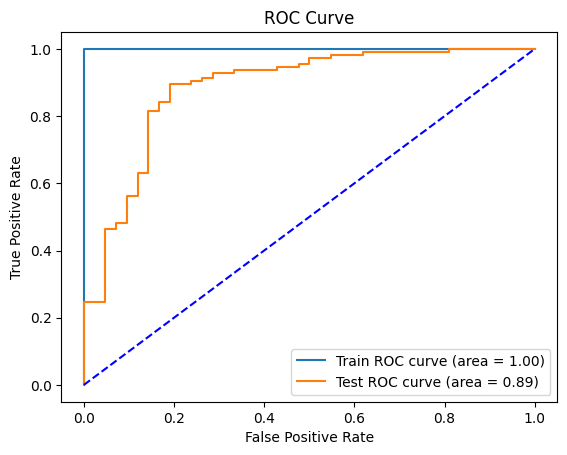

In [27]:
from sklearn import metrics
import matplotlib.pyplot as plt

train_fpr, train_tpr, train_thresholds = metrics.roc_curve(train_true, train_scores[:, 1])
train_roc_auc = metrics.auc(train_fpr, train_tpr)

test_fpr, test_tpr, test_thresholds = metrics.roc_curve(test_true, test_scores[:, 1])
test_roc_auc = metrics.auc(test_fpr, test_tpr)

plt.figure()
plt.plot(train_fpr, train_tpr, label=f'Train ROC curve (area = {train_roc_auc:.2f})')
plt.plot(test_fpr, test_tpr, label=f'Test ROC curve (area = {test_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], "b--")  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

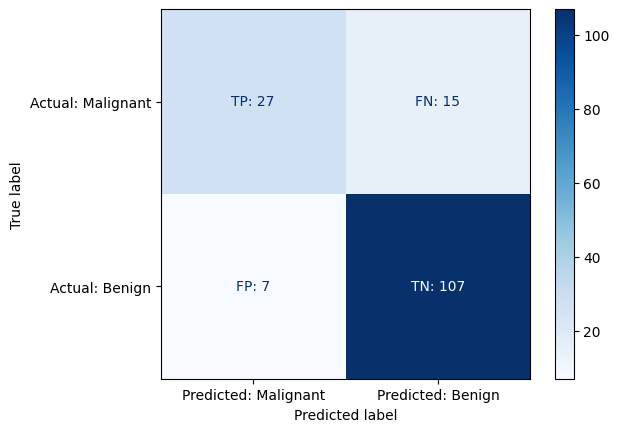

In [29]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# threshold = 0.5
# binary_test_scores = (test_scores[:, 1] >= threshold).to(torch.int)
# confusionMatrix = confusion_matrix(test_true.cpu(), test_scores.cpu())


# display_confusion_matrix = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix)
# display_confusion_matrix.plot(cmap="Blues")
# plt.show()


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

threshold = 0.5
# Assuming test_scores[:, 1] is the probability of the positive class
binary_test_scores = (test_scores[:, 1] >= threshold).cpu().numpy().astype(int)
confusionMatrix = confusion_matrix(test_true.cpu().numpy(), binary_test_scores)


fig, ax = plt.subplots()
labels = ['Malignant', 'Benign']

display_confusion_matrix = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix, display_labels=labels)
display_confusion_matrix.plot(cmap="Blues", ax=ax)

ax.set_xticklabels(['Predicted: Malignant', 'Predicted: Benign'])
ax.set_yticklabels(['Actual: Malignant', 'Actual: Benign'])


# Adjust the confusion matrix annotations for TP, FN, FP, TN
# The order may need to be changed based on how your confusionMatrix is organized
ax.texts[0].set_text(f'TP: {confusionMatrix[0, 0]}')
ax.texts[1].set_text(f'FN: {confusionMatrix[0, 1]}')
ax.texts[2].set_text(f'FP: {confusionMatrix[1, 0]}')
ax.texts[3].set_text(f'TN: {confusionMatrix[1, 1]}')

plt.show()



    True Positive (TP) - Model predicted the positive class. identifying a malignant tumour as malignant.
    True Negative (TN) - Model correctly predicted the negative class. For example, identifying a regular email as not spam.
    False Positive (FP) - Your model incorrectly predicted the positive class. For example, identifying a regular email as spam.
    False Negative (FN) - Your model incorrectly predicted the negative class. For example, identifying a spam email as a regular email.


# Deliverable 4